# **Classificatin models for drowsiness detection of driver**

****

In [1]:
pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [2]:
"importing libraries"
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import random
from tensorflow.keras.layers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau,CSVLogger
import pickle
from glob import glob
from sklearn.utils import shuffle
from patchify import patchify
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Extracting faces from images of three classes : ("active","yawning","drowsy").**

**Visualization of extracted face images from each class.**

-----------------------------------------------------------------------------------

			Images after extracting faces



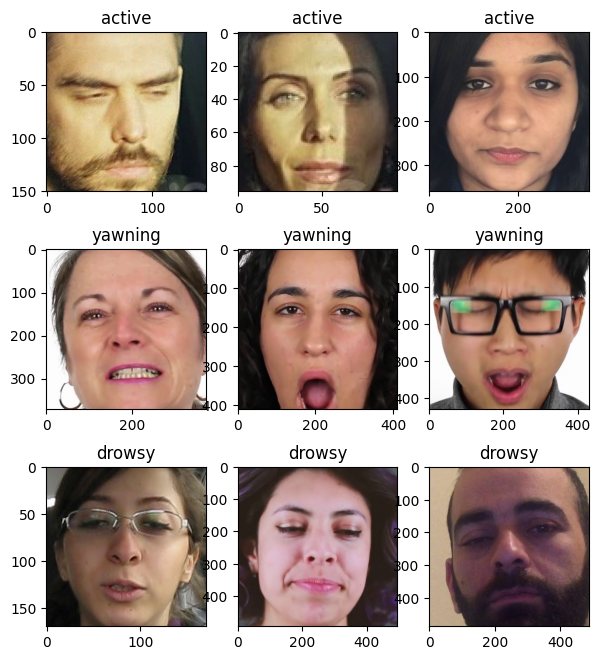

In [3]:
""" Visualization of images Before and after face extraction """

def display_images_from_classes(class_directories,class_names, num_images_to_display, num_rows, num_cols):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(7, 8))

    for class_index, class_directory in enumerate(class_directories):
        image_files = [f for f in os.listdir(class_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for i in range(num_images_to_display):
            if i < len(image_files):
                image_file = image_files[i]
                image_path = os.path.join(class_directory, image_file)
                image = Image.open(image_path)

                ax = axes[class_index, i]

                ax.imshow(image)
                ax.set_title(f'{class_names[class_index]}')

        for i in range(num_images_to_display, num_cols):
            ax = axes[class_index, i]
            ax.axis('off')
            
    for class_index in range(len(class_directories)):
        for i in range(num_images_to_display, num_cols):
            ax = axes[class_index, i]
            ax.axis('off')

    plt.show()
# print("------------------------------------------------------------------------\n")
# print("Images before face extraction")
# b1 = r"D:\Emotion_recognition\raw_data\active"
# b2 = r"D:\Emotion_recognition\raw_data\yawning"
# b3 = r"D:\Emotion_recognition\raw_data\drowsy"
# # Specify the directories for the three classes
# b_class_directories = [b1, b2, b3]
# b_class_names = ['active','yawning','drowsy']
# num_images_to_display = 3
# num_rows = len(b_class_directories)  # One row for each class
# num_cols = num_images_to_display
# display_images_from_classes(b_class_directories, b_class_names,num_images_to_display, num_rows, num_cols)



print("-----------------------------------------------------------------------------------\n")
print("\t\t\tImages after extracting faces\n")
a1 = "/kaggle/input/image-dataset/ddd_dataset/preprocessed_data/active"
a2 = "/kaggle/input/image-dataset/ddd_dataset/preprocessed_data/yawning"
a3 = "/kaggle/input/image-dataset/ddd_dataset/preprocessed_data/drowsy"
# Specify the directories for the three classes
a_class_directories = [a1, a2, a3]
a_class_names = ['active','yawning','drowsy']
num_images_to_display = 3
num_rows = len(a_class_directories)  # One row for each class
num_cols = num_images_to_display
display_images_from_classes(a_class_directories, a_class_names,num_images_to_display, num_rows, num_cols)



**Splitting the face images data into train(75%), val(15%) and test(15%).**

In [ ]:
# """    """
# def split_data_into_train_val_test(source_directory, destination_directory, train_split, validation_split, test_split):
#     # Create the destination directory if it doesn't exist
# #     if not os.path.exists(destination_directory):
# #         os.makedirs(destination_directory)

#     # Loop through the class folders in the source directory
#     for class_folder in os.listdir(source_directory):
#         class_directory = os.path.join(source_directory, class_folder)

#         # Create class-specific subdirectories in the destination directory
#         train_dir = os.path.join(destination_directory, 'train', class_folder)
#         validation_dir = os.path.join(destination_directory, 'validation', class_folder)
#         test_dir = os.path.join(destination_directory, 'test', class_folder)

#         for directory in [train_dir, validation_dir, test_dir]:
#             if not os.path.exists(directory):
#                 os.makedirs(directory)

        
#         image_files = [f for f in os.listdir(class_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

#         random.shuffle(image_files)

#         # Split the images into train, validation, and test sets
#         num_images = len(image_files)
#         num_train = int(train_split * num_images)
#         num_validation = int(validation_split * num_images)
#         num_test = int(test_split * num_images)

#         train_images = image_files[:num_train]
#         validation_images = image_files[num_train:num_train + num_validation]
#         test_images = image_files[num_train + num_validation:]

#         # Copy the images to their respective directories
#         for image in train_images:
#             source_path = os.path.join(class_directory, image)
#             destination_path = os.path.join(train_dir, image)
#             shutil.copy(source_path, destination_path)

#         for image in validation_images:
#             source_path = os.path.join(class_directory, image)
#             destination_path = os.path.join(validation_dir, image)
#             shutil.copy(source_path, destination_path)

#         for image in test_images:
#             source_path = os.path.join(class_directory, image)
#             destination_path = os.path.join(test_dir, image)
#             shutil.copy(source_path, destination_path)

#     print("Data split into train, validation, and test sets.\n")
    
# source_directory = "/kaggle/input/image-dataset/ddd_dataset/preprocessed_data" 
# destination_directory = "/kaggle/input/image-dataset/ddd_dataset/train_val_test" 
# train_split = 0.7
# validation_split = 0.15
# test_split = 0.15

# split_data_into_train_val_test(source_directory, destination_directory, train_split, validation_split, test_split)


***Data loading and augmentation***

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1.0/255.0,  
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=15,  # Rotate images by up to 15 degrees
    width_shift_range=0.15,  # Shift width by up to 15% of the image width
    height_shift_range=0.15,  # Shift height by up to 15% of the image height
    shear_range=0.15,  # Apply shear transformations with a max of 15%
    zoom_range=0.15,  # Zoom in/out by up to 15%
    horizontal_flip=True,  # Apply horizontal flips
    fill_mode='nearest',  # Fill empty areas with the nearest pixel
    brightness_range=[0.8, 1.2],  # Adjust brightness within this range
    channel_shift_range=10,  # Randomly shift color channels
)

train_generator = train_datagen.flow_from_directory(
    "/kaggle/input/image-dataset/ddd_dataset/train_val_test/train",  
    target_size=(224, 224),  
    batch_size=32,
    class_mode='categorical'  
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

validation_generator = validation_datagen.flow_from_directory(
    "/kaggle/input/image-dataset/ddd_dataset/train_val_test/validation",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    "/kaggle/input/image-dataset/ddd_dataset/train_val_test/test",  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3757 images belonging to 3 classes.
Found 801 images belonging to 3 classes.
Found 808 images belonging to 3 classes.


# InceptionV3 model for classification

In [ ]:
# """Using InceptionV3 model"""
# bmodel = InceptionV3(include_top=False, weights='imagenet', input_tensor=tf.keras.layers.Input(shape=(224,224,3)))
# hmodel = bmodel.output
# hmodel = tf.keras.layers.Flatten()(hmodel)
# hmodel = tf.keras.layers.Dense(64, activation='relu')(hmodel)
# hmodel = tf.keras.layers.Dropout(0.5)(hmodel)
# hmodel = tf.keras.layers.Dense(3,activation= 'softmax')(hmodel)
# # 
# model1 = Model(inputs=bmodel.input, outputs= hmodel)
# for layer in bmodel.layers:
#     layer.trainable = False

In [ ]:
# model1.summary()

In [ ]:
# earlystop = EarlyStopping(monitor = 'val_loss', patience=5, verbose= 3, restore_best_weights=True)
# learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )
# callbacks=[earlystop,learning_rate]

# model1.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy'])

# model1.fit_generator(train_generator,steps_per_epoch=train_generator.samples//32,
#                      validation_data=validation_generator,
#                      validation_steps=validation_generator.samples//32,
#                      callbacks=callbacks,epochs=100)

In [ ]:
# loss_tr, acc_tr = model1.evaluate(train_generator)
# print(acc_tr)
# # print(loss_tr)

In [ ]:
# loss_vr, acc_vr = model1.evaluate(validation_generator)
# print(acc_vr)
# # print(loss_vr)

In [ ]:
# loss_test, acc_test = model1.evaluate(test_generator)
# print(acc_test)
# # print(loss_test)

In [ ]:
# pickle.dump(model1,open('inceptionV3.h5','wb'))

# Vision tranformer for classification

In [5]:
""" Visoin Transformer model for classification"""
class ClassToken(Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     ## (None, 256, 3072)

    """ Patch + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1)
    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    embed = patch_embed + pos_embed ## (None, 256, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (None, 257, 768)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    x = Dense(cf["num_classes"], activation="softmax")(x)

    model = Model(inputs, x)
    return model


if __name__ == "__main__":
    config = {}
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 32
    config["num_channels"] = 3
    config["num_classes"] = 3

    model = ViT(config)
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 3072)]  0           []                               
                                                                                                  
 dense (Dense)                  (None, 256, 768)     2360064     ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 256, 768)    0           ['dense[0][0]']                  
 da)                                                                                              
                                                                                                  
 class_token (ClassToken)       (None, 1, 768)       768         ['tf.__operators__.add[0][0]'

In [6]:
""" Hyperparameters """
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])

hp["batch_size"] = 32
hp["lr"] = 1e-4
hp["num_epochs"] = 50
hp["num_classes"] = 3
hp["class_names"] = ["active", "drowsy", "yawning"]

hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1

def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*", "*.jpg")))

    split_size = int(len(images) * split)
    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)

    return train_x, valid_x, test_x

def process_image_label(path):
    """ Reading images """
    path = path.decode()
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0

    """ Preprocessing to patches """
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"])
    patches = patchify(image, patch_shape, hp["patch_size"])

    patches = np.reshape(patches, (64, 25, 25, 3))

    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    """ Label """
    class_name = path.split("/")[-2]
    class_idx = hp["class_names"].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return patches, class_idx

def parse(path):
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

    return patches, labels

def tf_dataset(images, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(8)
    return ds


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Paths """
    dataset_path = "/kaggle/input/image-dataset/ddd_dataset/preprocessed_data"

    """ Dataset """
    train_x, valid_x, test_x = load_data(dataset_path)
    print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}")

    train_ds = tf_dataset(train_x, batch=hp["batch_size"])
    valid_ds = tf_dataset(valid_x, batch=hp["batch_size"])

    """ Model """
    vitmodel = ViT(hp)
    vitmodel.compile(
        loss="categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
        metrics=["acc"]
    )

    callbacks = [
#         ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-10, verbose=1),
#         CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    ]

    history = vitmodel.fit(
        train_ds,
        epochs=hp["num_epochs"],
        validation_data=valid_ds,
        callbacks=callbacks
    )

Train: 4304 - Valid: 537 - Test: 537
Epoch 1/50
135/135 [==============================] - 180s 1s/step - loss: 1.4521 - acc: 0.3541 - val_loss: 1.0846 - val_acc: 0.4153 - lr: 1.0000e-04
Epoch 2/50
135/135 [==============================] - 132s 977ms/step - loss: 1.0555 - acc: 0.4663 - val_loss: 1.4000 - val_acc: 0.3557 - lr: 1.0000e-04
Epoch 3/50
135/135 [==============================] - 132s 977ms/step - loss: 0.7225 - acc: 0.7040 - val_loss: 0.6024 - val_acc: 0.7598 - lr: 1.0000e-04
Epoch 4/50
135/135 [==============================] - 132s 977ms/step - loss: 0.5210 - acc: 0.8025 - val_loss: 0.6173 - val_acc: 0.7337 - lr: 1.0000e-04
Epoch 5/50
135/135 [==============================] - 132s 977ms/step - loss: 0.4474 - acc: 0.8339 - val_loss: 0.4702 - val_acc: 0.8343 - lr: 1.0000e-04
Epoch 6/50
135/135 [==============================] - 132s 977ms/step - loss: 0.3680 - acc: 0.8685 - val_loss: 0.5395 - val_acc: 0.8175 - lr: 1.0000e-04
Epoch 7/50
135/135 [============================

In [29]:
pred = vitmodel.predict(test_ds)
pred[0]

17/17 [==============================] - 6s 321ms/step


array([8.1327401e-02, 9.1865861e-01, 1.4052445e-05], dtype=float32)

In [35]:
pred

array([[8.13274011e-02, 9.18658614e-01, 1.40524453e-05],
       [4.97147028e-07, 8.62523990e-08, 9.99999404e-01],
       [3.48654449e-01, 6.45797133e-01, 5.54840127e-03],
       ...,
       [5.68622816e-03, 2.40812570e-01, 7.53501236e-01],
       [1.19204815e-05, 9.99984860e-01, 3.25621590e-06],
       [1.91607378e-05, 1.13004000e-06, 9.99979734e-01]], dtype=float32)

In [36]:
vitmodel.save("vit_model.keras")

In [43]:
vitmodel.save_weights("vitweights.h5")

# Analysis and Plotting loss and accuracy values

In [44]:
"""Training loss and accuray values after each epoch"""
# epochs = hp["num_epochs"]
epochs = [i for i in range(1,27+1)]
loss_values = history.history['loss']
acc = history.history['acc']

"""Validation loss and accuray values after each epoch"""
vloss_values = history.history['val_loss']
vacc = history.history['val_acc']
# print(len(loss_values))
# print(len(epochs))

/tmp/ipykernel_239/2250577850.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vloss_values, 'b', color = 'g',label='Validation loss')
/tmp/ipykernel_239/2250577850.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, vacc, 'b', color = 'g',label='Validation accuracy')


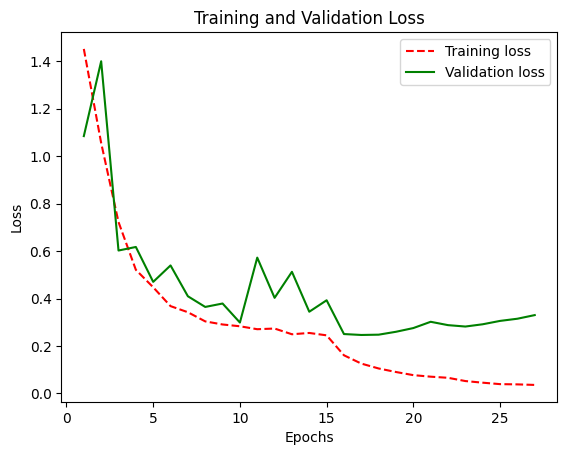

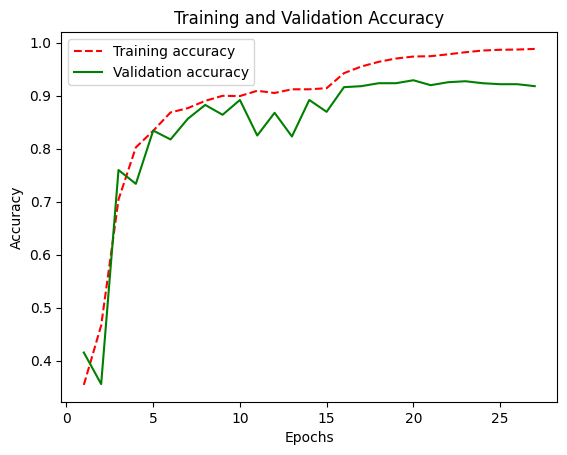

In [40]:


"""plotting values"""
# epochs = [i for i in range(len(hp['num_epochs']))]

# Plot training and validation loss
plt.plot(epochs, loss_values, '--', color = 'r',label='Training loss')
plt.plot(epochs, vloss_values, 'b', color = 'g',label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.figure()
plt.plot(epochs, acc, '--',color = 'r', label='Training accuracy')
plt.plot(epochs, vacc, 'b', color = 'g',label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [25]:
test_ds = tf_dataset(test_x, batch=hp["batch_size"])
vitmodel.evaluate(test_ds)

17/17 [==============================] - 7s 417ms/step - loss: 0.4664 - acc: 0.9050


[0.46638697385787964, 0.9050279259681702]